In [130]:
from datetime import datetime
start_real = datetime.now() # 全体の処理時間の計測を開始する

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

#### データの読み込み

In [131]:
# train = pd.read_csv("/kaggle/input/mercari-dataset/train.tsv", delimiter='\t')
# test = pd.read_csv("/kaggle/input/mercari-dataset/test.tsv", delimiter='\t')
train = pd.read_csv("train.tsv", delimiter='\t')
test = pd.read_csv("test.tsv", delimiter='\t')

#### データの全体像
train：1,482,535個のユーザーが投稿した商品

test：693,359行で「価格（Price）」の項目がテストデータは含まれていないため、列数は「7」となっている 

* train_id / test _id – ユーザー投稿のID
* name – 投稿のタイトル。タイトルに価格に関する情報がある場合（例：$20）はメルカリが事前に削除をして[rm]と置き換えている。
* item_condition_id – ユーザーが指定した商品の状態(1~5,大きい方が状態が良い)
* category_name – 投稿カテゴリー
* brand_name – ブランドの名前
* price – 訓練データのみ。実際に売られた価格。米ドル表示。今回のチャレンジの予測ターゲットとなる。
* shipping – 送料のフラグ。「1」は販売者負担。「0」は購入者負担。
* item_description – ユーザーが投稿した商品説明の全文。タイトルと同様に価格情報がある場合は[rm]と置き換えられている。

In [132]:
print(train.shape)
print(train.info())
display(train.head())

(1482535, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [133]:
print(test.shape)
print(test.info())
display(test.head())

(693359, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693359 entries, 0 to 693358
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   test_id            693359 non-null  int64 
 1   name               693359 non-null  object
 2   item_condition_id  693359 non-null  int64 
 3   category_name      690301 non-null  object
 4   brand_name         397834 non-null  object
 5   shipping           693359 non-null  int64 
 6   item_description   693359 non-null  object
dtypes: int64(3), object(4)
memory usage: 37.0+ MB
None


,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


#### ----------------- price -----------------

#### 3ドル未満のレコードを削除

>変更点2
>2000ドル以上を削除

In [134]:
train = train.drop(train[(train.price < 3.0) | (train.price > 2000.0)].index)
print(train.shape)
print(train["price"].min()) #priceの最小値
print(train["price"].max()) #priceの最大値

(1481658, 8)
3.0
2000.0


1,482,535→1,481,661点となり、874の商品が削除された

2000ドルよりも大きいさらに3点が削除された

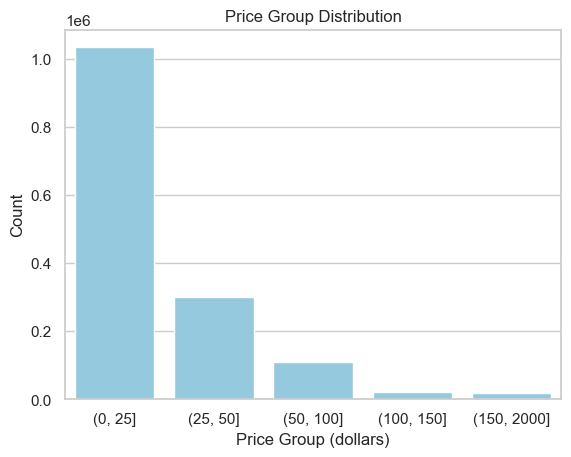

In [135]:
#0〜25，25~50,50~100,100～150,150~2000ドルの5つのグループに分けて個数をカウントして可視化
# price_groupの作成
train["price_group"] = pd.cut(train["price"], [0, 25, 50, 100, 150, 2000])

# Seabornのスタイルを設定
sns.set(style="whitegrid")

# price_groupのカウントプロットを作成
sns.countplot(x="price_group", data=train, color="skyblue")

#グラフのタイトルとラベルを設定
plt.title("Price Group Distribution")
plt.xlabel("Price Group (dollars)")
plt.ylabel("Count")
#price_group列はもう使わないので削除
train = train.drop("price_group", axis=1)


250ドル以上はほぼないと考え、3~250ドルの商品数を20ドルごとにヒストグラムで可視化

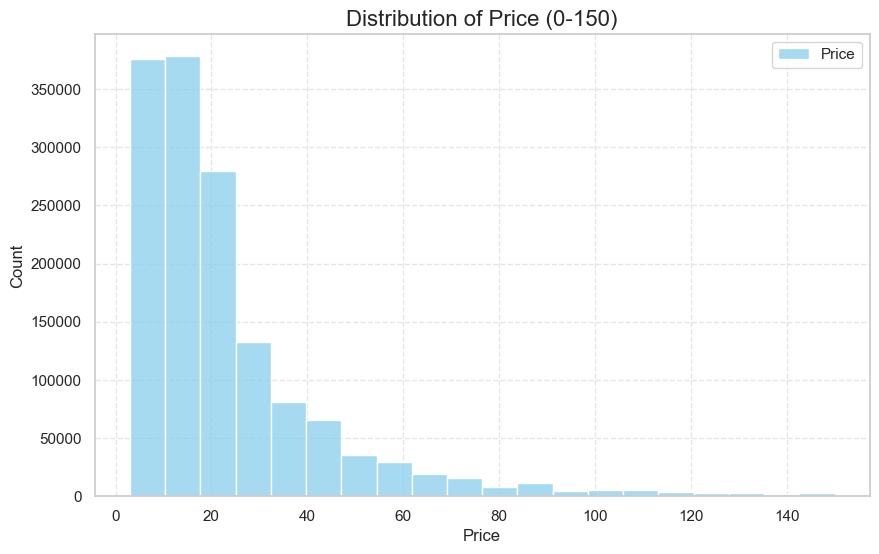

<function matplotlib.pyplot.show(close=None, block=None)>

In [136]:
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

sns.histplot(train[(train["price"] >= 0) & (train["price"] <= 150)]["price"], bins=20, kde=False, color='skyblue')

plt.title("Distribution of Price (0-150)", fontsize=16)
plt.ylabel("Count", fontsize=12)
plt.xlabel("Price", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(["Price"], loc='upper right')
plt.show()
plt.show

In [137]:
# #250ドルより大きいpriceを削除
# train = train.drop(train[(train.price > 250.0)].index)
# print(train["price"].max()) #priceの最大値

#### priceを対数変換して正規化

> 変更点2
> 正規化するために対数変換したが、3~250ドルに絞ったからわざわざ変換する必要ない?

In [138]:
# 訓練データの'price'を対数変換する
train['price'] = np.log1p(train['price'])

#### ----------------- category_name -----------------

#### general_category, sub_category1, sub_category2 に3等分する

In [139]:
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label") #categoryがない場合はNo Labelを返す

train['general_cat'], train['sub_cat1'], train['sub_cat2'] = zip(*train['category_name'].apply(lambda x: split_cat(x))) #zip(*df)で転置
train.head()
test['general_cat'], test['sub_cat1'], test['sub_cat2'] = zip(*test['category_name'].apply(lambda x: split_cat(x)))
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,general_cat,sub_cat1,sub_cat2
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7,Women,Jewelry,Rings
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,Shipping Supplies
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,Handbag
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,Cardigan
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...,Other,Books,Religion & Spirituality


#### train,testを縦方向に結合し、まとめて前処理できるようにする
> 変更点  
> trainデータフレームとtestデータフレームをpd.concat([train, test])で結合すると、1列目の列名が異なるため、test_id列が末尾にNaNとして挿入されてしまう。  
> これを避けるために、一度train_idとtest_idをidに変更し、列名を統一してから結合する。

In [140]:
# 列名をidに変更
train.rename(columns={'train_id': 'id'}, inplace=True) # <---
test.rename(columns={'test_id': 'id'}, inplace=True) # <---

# データフレームを結合
train_test_combine = pd.concat([train,test]) #axis=0で行、axis=1で列に結合 デフォルトはaxis=0
print(train_test_combine.shape)
train_test_combine.head()

(2175017, 11)


,id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,2.397895,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,3.583519,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,3.806662,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


train：1,482,535個の商品  
test：693,359個の商品  
train_test_combine：2,175,894個の商品

#### ----------------- brand_name -----------------

#### 欠損値処理
1. ブランド名の欠損値(NaN)を"missing"に置き換える
2. このままだと欠損値であることに変わりないので、"name(商品名)"が、ブランド名のリストに含まれる場合、ブランド名の"missing"を"name(商品名)"に書き換える

これにより、ブランド名(brand_name)が記載されていない商品でも、商品名(name)からブランド名を取得し、代入することができる

In [141]:
#brand_nameの重複なしのリストを作成
brand_name_list = set(train_test_combine["brand_name"].values) #set()で重複を削除

# 'brand_name'の欠損値NaNを'missing'に置き換える
train['brand_name'].fillna(value='missing', inplace=True)
test['brand_name'].fillna(value='missing', inplace=True)

# 訓練データの'brand_name'が'missing'に一致するレコード数を取得
train_premissing = len(train.loc[train['brand_name'] == 'missing'])
# テストデータの'brand_name'が'missing'に一致するレコード数を取得
test_premissing = len(test.loc[test['brand_name'] == 'missing'])

train_premissing, test_premissing #欠損値の数

(632336, 295525)

brand_name(trainデータ): 63万点のうち、13.7万点がブランド名を表すデータに書き換えられた  
brand_name(testデータ): 29万点のうち、6.4万点がブランド名を表すデータに書き換えられた

In [142]:
%%time
def brandfinder(line):
    brand = line[0] # 第1要素はブランド名
    name = line[1]  # 第2要素は商品名
    namesplit = name.split(' ') # 商品名をスペースで切り分ける
    
    if brand == 'missing':  # ブランド名が'missing'の場合
        for x in namesplit: # 商品名から切り分けた単語を取り出す
            if x in brand_name_list: # 単語がブランドリストに存在すればブランド名を返す              
                return name # 単語がブランドリストに一致したら商品名を返す
    if name in brand_name_list:  # 商品名がブランドリストに存在すれば商品名を返す
        return name
    
    return brand            # どれにも一致しなければブランド名を返す

# ブランド名の付替えを実施
train['brand_name'] = train[['brand_name','name']].apply(brandfinder, axis = 1) #axis=1で行方向
test['brand_name'] = test[['brand_name','name']].apply(brandfinder, axis = 1)

# 書き換えられた'missing'の数を取得
train_found = train_premissing-len(train.loc[train['brand_name'] == 'missing'])
test_found = test_premissing-len(test.loc[test['brand_name'] == 'missing'])

print(train_premissing) # 書き換える前の'missing'の数
print(train_found)      # 書き換えられた'missing'の数
print(test_premissing)  # 書き換える前の'missing'の数
print(test_found)       # 書き換えられた'missing'の数

632336
137342
295525
64154
CPU times: user 6.09 s, sys: 137 ms, total: 6.23 s
Wall time: 6.25 s


In [143]:
train.head()

,id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,MLB Cincinnati Reds T Shirt Size XL,2.397895,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,3.583519,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,3.806662,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


たとえば一行目の "brand_name" は missing → MLB Cincinnati となり、missingが"name(商品名)" に書き換えられたことがわかる

#### ----------------- エンコーディング (文字列→数値データ) -----------------

- name
- category_name
- brand_name
- item_description

の欠損値(NaN)を"missing"で埋める

In [144]:
#fillna()で欠損値を埋める
train_test_combine['name'].fillna(value='missing', inplace=True)
train_test_combine['category_name'].fillna(value='missing', inplace=True)
train_test_combine['general_cat'].fillna(value='missing', inplace=True)
train_test_combine['sub_cat1'].fillna(value='missing', inplace=True)
train_test_combine['sub_cat2'].fillna(value='missing', inplace=True)
train_test_combine['brand_name'].fillna(value='missing', inplace=True)
train_test_combine['item_description'].fillna(value='missing', inplace=True)

カテゴリカルデータ（離散的なカテゴリを持つデータ）である  
- category_name
- general_cat
- sub_cat1
- sub_cat2
- brand_name

を数値に変換

>変更点2
単なる数値変換ではなく、word2Vecを使う

In [145]:
#train_test_combineの型を確認
train_test_combine.dtypes

id                     int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
general_cat           object
sub_cat1              object
sub_cat2              object
dtype: object

### object→数値変換の手順
1. name, item_description: Word2Vec変換
2. category_name, brand_name, general_cat, sub_cat1, sub_cat2: Target Encoding

理由
1. 文章や単語列の意味を捉えるため、Word2Vec
2. カテゴリデータは文脈や単語の順序情報が少なく、Word2Vecの使用が最適ではない→ターゲット(price)との関係を反映した数値に変換

### 1. Word2Vec

#### 前処理(16分かかる)
TextHeroは、英語の前処理を簡単に行えるライブラリ

一般的に英語の前処理には、大文字を小文字に統一したり、空白の除去、StopWordsと呼ばれる(I,at,of,a,an)を除去する方法が用いられる

textheroのインストールでエラーが起きたから以下のコードを追加

In [146]:
!pip uninstall -y gensim numpy scipy
!pip install gensim numpy scipy

Found existing installation: gensim 4.3.3
Uninstalling gensim-4.3.3:
  Successfully uninstalled gensim-4.3.3
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: scipy 1.13.1
Uninstalling scipy-1.13.1:
  Successfully uninstalled scipy-1.13.1
  Using cached gensim-4.3.3-cp39-cp39-macosx_11_0_arm64.whl.metadata (8.3 kB)
  Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_arm64.whl.metadata (60 kB)
  Using cached scipy-1.13.1-cp39-cp39-macosx_12_0_arm64.whl.metadata (60 kB)
  Using cached numpy-1.26.4-cp39-cp39-macosx_11_0_arm64.whl.metadata (61 kB)
Using cached gensim-4.3.3-cp39-cp39-macosx_11_0_arm64.whl (24.0 MB)
Using cached numpy-1.26.4-cp39-cp39-macosx_11_0_arm64.whl (14.0 MB)
Using cached scipy-1.13.1-cp39-cp39-macosx_12_0_arm64.whl (30.3 MB)


In [147]:
#word2vecでname, item_descriptionをベクトル化するための前処理
import texthero as hero
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# NLTKのリソースをダウンロード
nltk.download('stopwords')
nltk.download('punkt')

# ステミングのためのPorterStemmerのインスタンスを作成
stemmer = PorterStemmer()

def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    return ' '.join(word for word in word_tokens if word.lower() not in stop_words)

def stem_text(text):
    word_tokens = word_tokenize(text)
    return ' '.join(stemmer.stem(word) for word in word_tokens)

def texthero_clean(input_df: pd.Series):
    '''
    英語の自然言語が含まれるDataFrameに対して、TextHeroを用いたクリーニング処理を行う。
    '''

    # テキストのクリーニング処理のパイプライン
    custom_pipeline = [
        hero.preprocessing.fillna, # null埋め
        hero.preprocessing.lowercase, # 全単語を小文字
        hero.preprocessing.remove_digits, # 数字を除去
        hero.preprocessing.remove_punctuation, # 句読点を除去
        hero.preprocessing.remove_diacritics, # 分音記号を除去
        hero.preprocessing.remove_whitespace, # 空白
    ]
    
    # テキストのクリーニング処理
    texts = hero.clean(input_df, custom_pipeline)
    
    # ストップワードの除去
    texts = texts.apply(remove_stopwords)
    
    # ステミングの適用 (runnnig -> run, cats -> cat, filles -> file)
    texts = texts.apply(stem_text)
    
    del input_df, custom_pipeline
    return texts

# データのクリーニング
train_test_combine['clean_name'] = texthero_clean(train_test_combine['name'])
train_test_combine['clean_item_description'] = texthero_clean(train_test_combine['item_description'])

[nltk_data] Downloading package stopwords to /Users/1612h/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/1612h/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [148]:
train_test_combine.head()

,id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2,clean_name,clean_item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,2.397895,1,No description yet,Men,Tops,T-shirts,mlb cincinnati red shirt size xl,descript yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,razer blackwidow chroma keyboard,keyboard great condit work like came box port ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,ava viv blous,ador top hint lace key hole back pale pink 1x ...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,3.583519,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,leather hors statu,new tag leather hors retail rm stand foot high...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,3.806662,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,24k gold plate rose,complet certif authent


In [149]:
train_test_combine.to_csv('train_test_combine_texthero.csv', index=False) 

In [150]:
#train_test_combine_texthero.csvを読み込む
train_test_combine = pd.read_csv('train_test_combine_texthero.csv')

In [151]:
#train_test_combineの型を確認
print(train_test_combine.dtypes)
#name,clean_name, item_description, clean_item_descriptionの先頭5行を表示
train_test_combine[['name', 'clean_name','item_description', 'clean_item_description']].head()

id                          int64
name                       object
item_condition_id           int64
category_name              object
brand_name                 object
price                     float64
shipping                    int64
item_description           object
general_cat                object
sub_cat1                   object
sub_cat2                   object
clean_name                 object
clean_item_description     object
dtype: object


,name,clean_name,item_description,clean_item_description
0,MLB Cincinnati Reds T Shirt Size XL,mlb cincinnati red shirt size xl,No description yet,descript yet
1,Razer BlackWidow Chroma Keyboard,razer blackwidow chroma keyboard,This keyboard is in great condition and works ...,keyboard great condit work like came box port ...
2,AVA-VIV Blouse,ava viv blous,Adorable top with a hint of lace and a key hol...,ador top hint lace key hole back pale pink 1x ...
3,Leather Horse Statues,leather hors statu,New with tags. Leather horses. Retail for [rm]...,new tag leather hors retail rm stand foot high...
4,24K GOLD plated rose,24k gold plate rose,Complete with certificate of authenticity,complet certif authent


#### 単語のベクトル化
Word2Vecは単語のベクトル表現のうち、SkipGramという手法で学習された単語のベクトル表現の1つである。SkipGramは、単語を前後の単語の出現頻度を測定することで、その単語のベクトル表現を獲得する手法

今回は自分で新規に学習してWord2Vecのモデルを作成するのではなく、公開されている学習済み重みを利用するパターンで実装を行う。広く利用されているものとして、Googleが公開しているGoogleNews-vectors-negative300がある。こちらはGoogle News Datasetに含まれる100億単語を学習して作成されたもので、入力した単語を300次元のベクトルに変換できる。(ダウンロードリンク：https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g)

In [152]:
# Word2Vec用のクラス
import gensim

class SentenceVectorizer():
    def __init__(self, model_name="fasttext"):
        if model_name == "fasttext":
            self._model = gensim.models.KeyedVectors.load_word2vec_format(
                "../signate-paper/Fasttext-vectors300.vec", binary=False
            )
        elif model_name == "googlenews":
            self._model = gensim.models.KeyedVectors.load_word2vec_format(
                "GoogleNews-vectors-negative300.bin", binary=True
            )
        else:
            exit()
        self.out_dim = 300
        self.model_name = model_name

    def vectorize(self, sentence: str) -> pd.Series:
        """
        1つの文章に対するWord2Vecの処理の実行
        """
        func = np.median
        return pd.Series(func(
            [self._model[w] for w in sentence.split(" ") if w in self._model],
            axis=0,
        ))
        
    def fit_transform(self, input_df: pd.DataFrame, col_prefix: str = ''):
        """
        入力されたデータフレームに対してWord2Vecを実行する。
        col_prefixに任意の文字列を指定することで、カラムに任意の接頭詞付与する。
        """
        _prefix = self.model_name
        if col_prefix:
            _prefix = col_prefix + '_' + _prefix
        columns=[_prefix + f'_{i:03}' for i in range(self.out_dim)]
        vectorized_np = input_df.apply(self.vectorize)
        resoponse_df = pd.DataFrame(vectorized_np.values, columns=columns)
        del columns, vectorized_np, col_prefix, input_df
        return resoponse_df

ベクトル化(object→数値型)は11~17分かかる

In [153]:
# NaN値を空文字列に置き換える
train_test_combine['clean_name'] = train_test_combine['clean_name'].fillna('')
train_test_combine['clean_item_description'] = train_test_combine['clean_item_description'].fillna('')

g_model_vectorizer = SentenceVectorizer('googlenews')
gnews_name = g_model_vectorizer.fit_transform(train_test_combine['clean_name'], 'gnews_name')
gnews_item_description = g_model_vectorizer.fit_transform(train_test_combine['clean_item_description'], 'gnews_item_description')

In [154]:
train_test_combine.to_csv('train_test_combine_texthero.csv', index=False) 

In [155]:
gnews_name.head()

,gnews_name_googlenews_000,gnews_name_googlenews_001,gnews_name_googlenews_002,gnews_name_googlenews_003,gnews_name_googlenews_004,gnews_name_googlenews_005,gnews_name_googlenews_006,gnews_name_googlenews_007,gnews_name_googlenews_008,gnews_name_googlenews_009,...,gnews_name_googlenews_290,gnews_name_googlenews_291,gnews_name_googlenews_292,gnews_name_googlenews_293,gnews_name_googlenews_294,gnews_name_googlenews_295,gnews_name_googlenews_296,gnews_name_googlenews_297,gnews_name_googlenews_298,gnews_name_googlenews_299
0,-0.089294,-0.022156,0.116455,0.175293,-0.014648,-0.054565,-0.013672,-0.184082,0.065155,0.037079,...,0.058594,0.089111,-0.070923,-0.055054,0.066895,-0.082275,0.032227,-0.072632,-0.106445,0.069580
1,0.010803,0.072754,-0.041748,-0.045898,-0.087891,0.062256,0.079102,-0.033447,0.079102,0.139648,...,-0.112793,0.176758,-0.125977,0.007080,0.028564,-0.059326,0.084473,-0.053223,-0.182617,0.091309
2,-0.045135,-0.062988,-0.038116,0.019409,-0.016907,-0.056992,0.022461,-0.115479,-0.043579,0.010498,...,0.035065,0.071869,-0.072266,-0.018372,0.062500,0.017334,-0.119690,-0.068359,-0.044556,0.124023
3,-0.013306,0.008667,-0.033691,0.063965,0.086914,0.023315,-0.019653,-0.210938,0.017700,0.100586,...,0.051270,-0.065430,0.026733,0.055908,0.040527,0.006226,0.202148,0.021606,-0.023804,0.110352
4,-0.208008,0.041260,-0.027954,0.070801,0.123047,-0.186523,0.076172,-0.146484,0.105469,0.230469,...,-0.001312,-0.014282,-0.326172,0.108887,0.019653,-0.005676,0.110840,-0.081055,0.259766,-0.036377


#### 主成分成分分析(PCA)
単語のベクトル表現は、多くの場合が高次元のベクトルのため、機械学習などで用いられる場合、次元削減により次元圧縮した後に利用されることが多い。

次元削減の代表といえば、主成分分析(PCA)がある。こちらはsklearnで実装済みのものがあるので、簡単に利用可能である。

In [156]:
from sklearn.decomposition import PCA

def pca_reduce(input_df: pd.Series, col_prefix: str=None, n_components: int=2):
    """PCAで圧縮
    """
    _prefix = "pca"
    if col_prefix:
        _prefix = col_prefix + '_' + _prefix
    columns=[_prefix + f'_{i:03}' for i in range(n_components)]
    return pd.DataFrame(
            PCA(n_components=n_components).fit_transform(input_df),
            columns=columns,
        )

In [157]:
#gnews_name, gnews_item_descriptionの欠損値数
print(gnews_name.isnull().sum().sum())
print(gnews_item_description.isnull().sum().sum())

22857000
4755900


In [158]:
#欠損値を削除
#!  errorの原因かも
gnews_name = gnews_name.dropna()
gnews_item_description = gnews_item_description.dropna()

In [159]:
#gnews_name, gnews_item_descriptionの欠損値数
print(gnews_name.isnull().sum().sum())
print(gnews_item_description.isnull().sum().sum())

0
0


In [160]:
gnews_name_pca = pca_reduce(gnews_name, 'gnews_name',2)
gnews_item_description_pca = pca_reduce(gnews_item_description, 'gnews_item_description',2)
gnews_name_pca.head()

,gnews_name_pca_000,gnews_name_pca_001
0,-0.279060,0.256738
1,-0.247681,-0.044376
2,-0.772200,0.125368
3,-0.352742,0.072458
4,0.383611,-0.368765


In [161]:
#train_test_combineにgnews_name_pca, gnews_item_description_pcaを結合
train_test_combine = pd.concat([train_test_combine.reset_index(drop=True), gnews_name_pca.reset_index(drop=True), gnews_item_description_pca.reset_index(drop=True)], axis=1) #drop=Trueで元のインデックスを削除
train_test_combine.head()

,id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,sub_cat2,clean_name,clean_item_description,gnews_name_pca_000,gnews_name_pca_001,gnews_item_description_pca_000,gnews_item_description_pca_001
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,2.397895,1,No description yet,Men,Tops,T-shirts,mlb cincinnati red shirt size xl,descript yet,-0.279060,0.256738,-0.872907,0.448636
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,razer blackwidow chroma keyboard,keyboard great condit work like came box port ...,-0.247681,-0.044376,-0.214634,-0.010497
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,ava viv blous,ador top hint lace key hole back pale pink 1x ...,-0.772200,0.125368,0.093257,0.114212
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,3.583519,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,leather hors statu,new tag leather hors retail rm stand foot high...,-0.352742,0.072458,-0.157154,-0.227233
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,3.806662,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,24k gold plate rose,complet certif authent,0.383611,-0.368765,-0.058831,0.098200


In [162]:
train_test_combine.dtypes

id                                  int64
name                               object
item_condition_id                   int64
category_name                      object
brand_name                         object
price                             float64
shipping                            int64
item_description                   object
general_cat                        object
sub_cat1                           object
sub_cat2                           object
clean_name                         object
clean_item_description             object
gnews_name_pca_000                float64
gnews_name_pca_001                float64
gnews_item_description_pca_000    float64
gnews_item_description_pca_001    float64
dtype: object

In [163]:
train_test_combine.to_csv('train_test_combine_pca.csv', index=False) 

## 2. Target Encoding(category_name, brand_name, general_cat, sub_cat1, sub_cat2)

各カテゴリに対してターゲット変数の平均値などを割り当てる方法です。たとえば、カテゴリが「A」の場合、そのカテゴリのターゲット変数(price)の平均価格を割り当てます。

例：カテゴリ：Makeup → ターゲット変数:Makeupのpriceの平均価格

In [164]:
# ターゲットエンコーディング関数
def target_encode(train_test_combine, cat_col, target_col):
    # ターゲットの平均値を計算
    mean_target = train_test_combine[target_col].mean()
    
    # カテゴリごとの平均ターゲット値を計算
    agg = train_test_combine.groupby(cat_col).agg({target_col: ['mean', 'count']})
    agg.columns = ['mean', 'count']
    
    # スムージングパラメータ
    smooth_factor = 1
    agg['smooth'] = (agg['mean'] * agg['count'] + mean_target * smooth_factor) / (agg['count'] + smooth_factor)
    
    # ターゲットエンコーディングを適用
    train_test_combine = train_test_combine.merge(agg[['smooth']], left_on=cat_col, right_index=True, how='left')
    
    # カラム名を変更
    train_test_combine.rename(columns={'smooth': cat_col + '_encoded'}, inplace=True)
    
    return train_test_combine

# 各カテゴリ変数に対してターゲットエンコーディングを適用
for cat_col in ['category_name', 'brand_name', 'general_cat', 'sub_cat1', 'sub_cat2']:
    train_test_combine = target_encode(train_test_combine, cat_col, 'price')

In [165]:
train_test_combine.head()

,id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,...,clean_item_description,gnews_name_pca_000,gnews_name_pca_001,gnews_item_description_pca_000,gnews_item_description_pca_001,category_name_encoded,brand_name_encoded,general_cat_encoded,sub_cat1_encoded,sub_cat2_encoded
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,2.397895,1,No description yet,Men,Tops,...,descript yet,-0.279060,0.256738,-0.872907,0.448636,2.774219,2.802789,3.231123,2.802184,2.774219
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,...,keyboard great condit work like came box port ...,-0.247681,-0.044376,-0.214634,-0.010497,3.336386,3.687401,2.987666,3.813956,3.336386
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,...,ador top hint lace key hole back pale pink 1x ...,-0.772200,0.125368,0.093257,0.114212,2.649776,2.641009,3.082521,2.779214,2.649766
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,3.583519,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,...,new tag leather hors retail rm stand foot high...,-0.352742,0.072458,-0.157154,-0.227233,2.911043,2.802789,2.992486,2.895959,2.911043
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,3.806662,0,Complete with certificate of authenticity,Women,Jewelry,...,complet certif authent,0.383611,-0.368765,-0.058831,0.098200,2.730138,2.802789,3.082521,2.830890,2.730138


In [166]:
train_test_combine.to_csv('train_test_combine_target_encoding.csv', index=False) 

#### 前処理後の結合したデータ(train_test_combine)を再びtrain,testデータに分割する
> 変更点  
> idとした列名を、再びtrain_id, test_idに戻す

In [167]:
#train_test_combineからtrainとtestに分割
train = train_test_combine[:len(train)]
train.rename(columns={'id': 'train_id'}, inplace=True) # <---

test = train_test_combine[len(train):]
test.rename(columns={'id': 'test_id'}, inplace=True) # <---


In [168]:
print(train.shape)
print(train.info())
display(train.head())

(1481658, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1481658 entries, 0 to 1481657
Data columns (total 22 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   train_id                        1481658 non-null  int64  
 1   name                            1481658 non-null  object 
 2   item_condition_id               1481658 non-null  int64  
 3   category_name                   1481658 non-null  object 
 4   brand_name                      1481658 non-null  object 
 5   price                           1481658 non-null  float64
 6   shipping                        1481658 non-null  int64  
 7   item_description                1481658 non-null  object 
 8   general_cat                     1481658 non-null  object 
 9   sub_cat1                        1481658 non-null  object 
 10  sub_cat2                        1481658 non-null  object 
 11  clean_name                      1481658 non-null 

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,...,clean_item_description,gnews_name_pca_000,gnews_name_pca_001,gnews_item_description_pca_000,gnews_item_description_pca_001,category_name_encoded,brand_name_encoded,general_cat_encoded,sub_cat1_encoded,sub_cat2_encoded
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,2.397895,1,No description yet,Men,Tops,...,descript yet,-0.279060,0.256738,-0.872907,0.448636,2.774219,2.802789,3.231123,2.802184,2.774219
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,...,keyboard great condit work like came box port ...,-0.247681,-0.044376,-0.214634,-0.010497,3.336386,3.687401,2.987666,3.813956,3.336386
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,...,ador top hint lace key hole back pale pink 1x ...,-0.772200,0.125368,0.093257,0.114212,2.649776,2.641009,3.082521,2.779214,2.649766
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,3.583519,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,...,new tag leather hors retail rm stand foot high...,-0.352742,0.072458,-0.157154,-0.227233,2.911043,2.802789,2.992486,2.895959,2.911043
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,3.806662,0,Complete with certificate of authenticity,Women,Jewelry,...,complet certif authent,0.383611,-0.368765,-0.058831,0.098200,2.730138,2.802789,3.082521,2.830890,2.730138


In [169]:
print(test.shape)
print(test.info())
display(test.head())

(693359, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693359 entries, 1481658 to 2175016
Data columns (total 22 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   test_id                         693359 non-null  int64  
 1   name                            693359 non-null  object 
 2   item_condition_id               693359 non-null  int64  
 3   category_name                   693359 non-null  object 
 4   brand_name                      693359 non-null  object 
 5   price                           0 non-null       float64
 6   shipping                        693359 non-null  int64  
 7   item_description                693359 non-null  object 
 8   general_cat                     693359 non-null  object 
 9   sub_cat1                        693359 non-null  object 
 10  sub_cat2                        693359 non-null  object 
 11  clean_name                      693359 non-null  object 
 

,test_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,sub_cat1,...,clean_item_description,gnews_name_pca_000,gnews_name_pca_001,gnews_item_description_pca_000,gnews_item_description_pca_001,category_name_encoded,brand_name_encoded,general_cat_encoded,sub_cat1_encoded,sub_cat2_encoded
1481658,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,missing,NaN,1,Size 7,Women,Jewelry,...,size,0.032240,-0.075378,-0.154753,-0.161337,2.933085,2.802789,3.082521,2.830890,2.933085
1481659,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,missing,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined...",Other,Office supplies,...,pc new 7 5 x12 kraft bubbl mailer line bubbl w...,-0.051644,0.409262,-0.020896,0.143996,2.347842,2.802789,2.754772,2.591055,2.347842
1481660,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,NaN,1,Brand new coach bag. Bought for [rm] at a Coac...,Vintage & Collectibles,Bags and Purses,...,brand new coach bag bought rm coach outlet,0.038284,-0.290604,-0.167546,-0.101041,4.185760,3.508062,2.898409,3.495135,4.185760
1481661,3,Floral Kimono,2,Women/Sweaters/Cardigan,missing,NaN,0,-floral kimono -never worn -lightweight and pe...,Women,Sweaters,...,floral kimono never worn lightweight perfect h...,-0.899987,0.103280,-0.178724,-0.116243,3.043670,2.802789,3.082521,3.095597,3.042233
1481662,4,Life after Death,3,Other/Books/Religion & Spirituality,missing,NaN,1,Rediscovering life after the loss of a loved o...,Other,Books,...,rediscov life loss love one toni cook paperbac...,-0.470289,-0.481861,-0.037063,0.040666,2.538821,2.802789,2.754772,2.619544,2.538821


In [170]:
# trainの欠損値数
print(train.isnull().sum())

train_id                          0
name                              0
item_condition_id                 0
category_name                     0
brand_name                        0
price                             0
shipping                          0
item_description                  0
general_cat                       0
sub_cat1                          0
sub_cat2                          0
clean_name                        0
clean_item_description            0
gnews_name_pca_000                0
gnews_name_pca_001                0
gnews_item_description_pca_000    0
gnews_item_description_pca_001    0
category_name_encoded             0
brand_name_encoded                0
general_cat_encoded               0
sub_cat1_encoded                  0
sub_cat2_encoded                  0
dtype: int64


In [171]:
# testの欠損値数
print(test.isnull().sum())

test_id                                0
name                                   0
item_condition_id                      0
category_name                          0
brand_name                             0
price                             693359
shipping                               0
item_description                       0
general_cat                            0
sub_cat1                               0
sub_cat2                               0
clean_name                             0
clean_item_description                 0
gnews_name_pca_000                 76190
gnews_name_pca_001                 76190
gnews_item_description_pca_000     15853
gnews_item_description_pca_001     15853
category_name_encoded                 30
brand_name_encoded                   588
general_cat_encoded                    0
sub_cat1_encoded                       0
sub_cat2_encoded                      17
dtype: int64


#### 前処理後データの保存

In [172]:
#trainとtestの前処理後のデータを保存
train.to_csv('train_finish.csv', index=False) 
test.to_csv('test_finish.csv', index=False)

In [173]:
#train_test_combine_texthero.csvを読み込む
train = pd.read_csv('train_finish.csv')
test = pd.read_csv('test_finish.csv')

#### -------------------- 前処理終了 --------------------

#### モデルの作成と学習

#### 説明変数と目的変数の数値を分ける
> 変更点  
> エンコーディングする前の列は説明変数に加えない。  
> 情報の重複と多重共線性のリスクを避けるためである。エンコーディングされたデータは元のテキストデータの情報を包含しているため、元の列を残すと過剰な情報がモデルの性能を低下させる可能性がある。

> 変更点2 
> 追加した列を考慮して削除

brand_name, general_cat, sub_cat1, sub_cat2, clean_name, clean_item_descriptionを追加で削除

In [174]:
train.dtypes

train_id                            int64
name                               object
item_condition_id                   int64
category_name                      object
brand_name                         object
price                             float64
shipping                            int64
item_description                   object
general_cat                        object
sub_cat1                           object
sub_cat2                           object
clean_name                         object
clean_item_description             object
gnews_name_pca_000                float64
gnews_name_pca_001                float64
gnews_item_description_pca_000    float64
gnews_item_description_pca_001    float64
category_name_encoded             float64
brand_name_encoded                float64
general_cat_encoded               float64
sub_cat1_encoded                  float64
sub_cat2_encoded                  float64
dtype: object

In [175]:
X = train.drop(columns=['train_id', 'name', 'category_name', 'price', 'item_description', 'brand_name', 'general_cat', 'sub_cat1', 'sub_cat2', 'clean_name', 'clean_item_description'])
y = np.expm1(train['price'])
print('X:', X.shape)
display(X.head())
print('y:', y.shape)
print(y.head())

X: (1481658, 11)


,item_condition_id,shipping,gnews_name_pca_000,gnews_name_pca_001,gnews_item_description_pca_000,gnews_item_description_pca_001,category_name_encoded,brand_name_encoded,general_cat_encoded,sub_cat1_encoded,sub_cat2_encoded
0,3,1,-0.279060,0.256738,-0.872907,0.448636,2.774219,2.802789,3.231123,2.802184,2.774219
1,3,0,-0.247681,-0.044376,-0.214634,-0.010497,3.336386,3.687401,2.987666,3.813956,3.336386
2,1,1,-0.772200,0.125368,0.093257,0.114212,2.649776,2.641009,3.082521,2.779214,2.649766
3,1,1,-0.352742,0.072458,-0.157154,-0.227233,2.911043,2.802789,2.992486,2.895959,2.911043
4,1,0,0.383611,-0.368765,-0.058831,0.098200,2.730138,2.802789,3.082521,2.830890,2.730138


y: (1481658,)
0    10.0
1    52.0
2    10.0
3    35.0
4    44.0
Name: price, dtype: float64


In [176]:
#yの最大値と最小値
print(y.min())
print(y.max())

3.0
2000.0


#### Xとyのうち、7割を訓練用(train)、3割を検証用(test)に分割する

In [177]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [178]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1037160, 11)
(1037160,)
(444498, 11)
(444498,)


In [179]:
#それぞれの欠損値数を確認
print("X_train : ", X_train.isnull().sum())
print()
print("y_train : ", y_train.isnull().sum())
print()
print("X_test : ", X_test.isnull().sum())
print()
print("y_test : ", y_test.isnull().sum())

X_train :  item_condition_id                 0
shipping                          0
gnews_name_pca_000                0
gnews_name_pca_001                0
gnews_item_description_pca_000    0
gnews_item_description_pca_001    0
category_name_encoded             0
brand_name_encoded                0
general_cat_encoded               0
sub_cat1_encoded                  0
sub_cat2_encoded                  0
dtype: int64

y_train :  0

X_test :  item_condition_id                 0
shipping                          0
gnews_name_pca_000                0
gnews_name_pca_001                0
gnews_item_description_pca_000    0
gnews_item_description_pca_001    0
category_name_encoded             0
brand_name_encoded                0
general_cat_encoded               0
sub_cat1_encoded                  0
sub_cat2_encoded                  0
dtype: int64

y_test :  0


priceのNaNを60万個消したのは気になるが、一旦は欠損値処理含めて前処理完了

#### モデルの学習

In [180]:
%%time
!pip install lightgbm
import lightgbm as lgb

lgbm = lgb.LGBMRegressor(n_estimators=200, max_depth=10, random_state=0, n_jobs=-1)
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002999 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1862
[LightGBM] [Info] Number of data points in the train set: 1037160, number of used features: 11
[LightGBM] [Info] Start training from score 26.723941
CPU times: user 5.14 s, sys: 2.46 s, total: 7.61 s
Wall time: 2.66 s


LGBMRegressor(max_depth=10, n_estimators=200, n_jobs=-1, random_state=0)

#### モデルの特徴重要度

In [181]:
ser_fi = pd.Series(lgbm.feature_importances_, index=X_train.columns)
print(ser_fi.sort_values(ascending=False))

brand_name_encoded                1309
category_name_encoded              780
gnews_item_description_pca_001     564
gnews_name_pca_001                 550
gnews_item_description_pca_000     524
gnews_name_pca_000                 511
item_condition_id                  500
sub_cat2_encoded                   489
sub_cat1_encoded                   433
general_cat_encoded                181
shipping                           159
dtype: int32


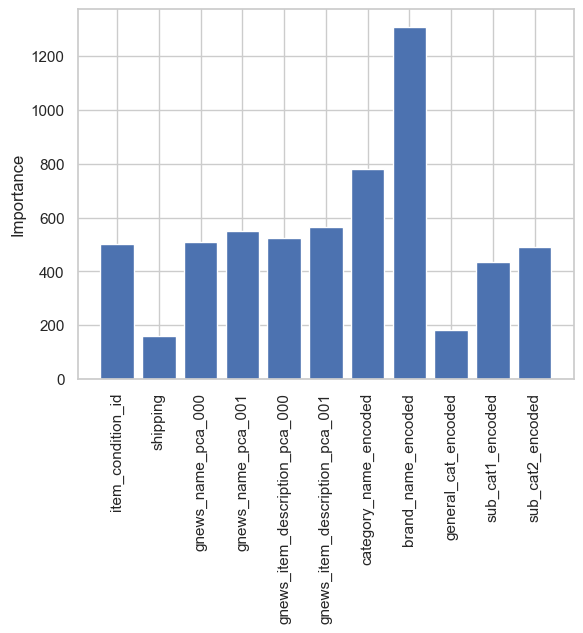

In [182]:
plt.bar(X_train.columns, lgbm.feature_importances_)
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.show()

#### 訓練データに対する予測

In [183]:
y_train_pred = lgbm.predict(X_train)

In [184]:
y_min = np.append(y_train_pred, y_train).min()
y_max = np.append(y_train_pred, y_train).max()
y_margin = (y_max - y_min) * 0.1
y_min -= y_margin
y_max += y_margin

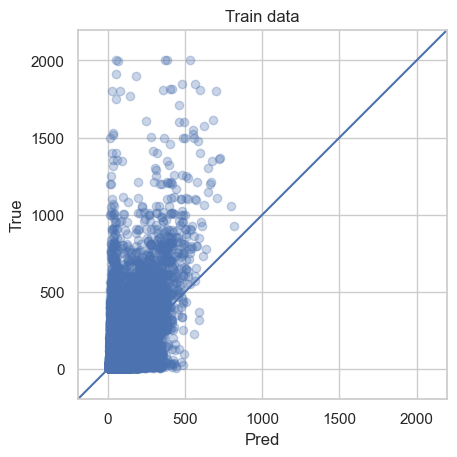

In [185]:
plt.scatter(y_train_pred, y_train, alpha=0.3)
plt.plot([y_min,y_max], [y_min,y_max])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(y_min, y_max)
plt.ylim(y_min, y_max)
plt.title('Train data')
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()

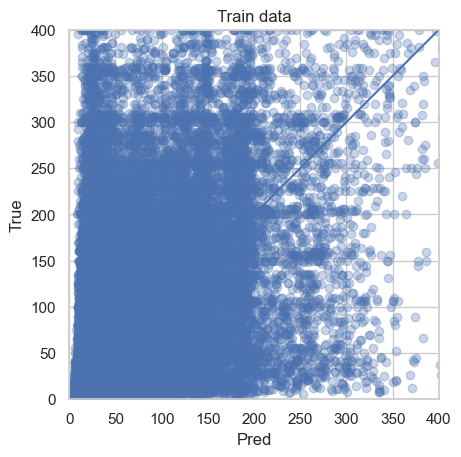

In [186]:
plt.scatter(y_train_pred, y_train, alpha=0.3)
plt.plot([y_min,y_max], [y_min,y_max])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0, 400) # <---
plt.ylim(0, 400) # <---
plt.title('Train data')
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()

In [187]:
from sklearn.metrics import mean_squared_log_error

# RMSLE関数の定義
def rmsle(y_true, y_pred):
    # クリップして無限大や非常に大きな値を避ける
    y_true_clipped = np.clip(y_true, 0, np.log(np.finfo(np.float64).max))
    y_pred_clipped = np.clip(y_pred, 0, np.log(np.finfo(np.float64).max))
    
    return np.sqrt(mean_squared_log_error(y_true_clipped, y_pred_clipped))

In [188]:
y_test_pred = lgbm.predict(X_test)

In [189]:
# モデルの評価
print("RMSLE for train data:", rmsle(np.expm1(y_train), np.expm1(y_train_pred)))

RMSLE for train data: 0.5364820635814853


#### テストデータに対する予測

In [190]:
y_test_pred = lgbm.predict(X_test)

In [191]:
y_min = np.append(y_test_pred, y_test).min()
y_max = np.append(y_test_pred, y_test).max()
y_margin = (y_max - y_min) * 0.1
y_min -= y_margin
y_max += y_margin

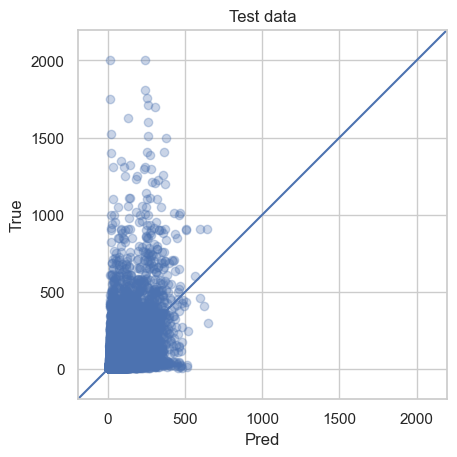

In [192]:
plt.scatter(y_test_pred, y_test, alpha=0.3)
plt.plot([y_min,y_max], [y_min,y_max])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(y_min, y_max)
plt.ylim(y_min, y_max)
plt.title('Test data')
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()

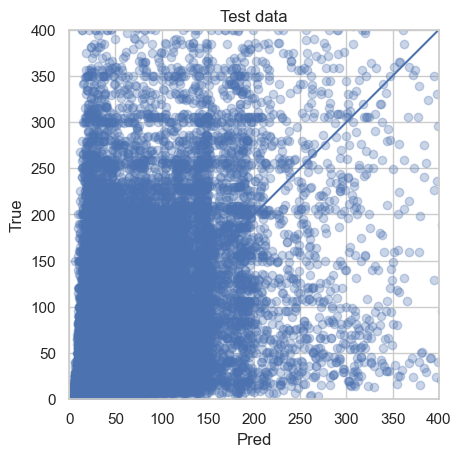

In [193]:
plt.scatter(y_test_pred, y_test, alpha=0.3)
plt.plot([y_min,y_max], [y_min,y_max])
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0, 400) # <---
plt.ylim(0, 400) # <---
plt.title('Test data')
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()

In [194]:
# モデルの評価
print("RMSLE for test data:", rmsle(np.expm1(y_test), np.expm1(y_test_pred)))

RMSLE for test data: 0.5394024783550159


In [195]:
stop_real = datetime.now()
execution_time_real = stop_real - start_real
print(execution_time_real)

0:29:32.749829
